Cosumnes Model 
@author: Andrew

In [123]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time
from scipy.stats import gmean

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [124]:

# run installed version of flopy or add local path
try:
    import flopy
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
except:
    import flopy
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
from flopy.utils.gridgen import Gridgen
from flopy.utils import OptionBlock
import flopy.utils.binaryfile as bf


print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.21.2
matplotlib version: 3.4.3
flopy version: 3.3.4


In [125]:

# Transient -> might want to think about making SP1 steady
end_date = '2018-01-2'
# end_date = '2018-01-02'
strt_date = '2018-01-01'

dates = pd.date_range(strt_date, end_date)

# The number of periods is the number of dates 
nper = len(dates)+1

# Each period has a length of one because the timestep is one day, have the 1st stress period be out of the date range
# need to have the transient packages start on the second stress period
perlen = np.ones(nper)
# Steady or transient periods
steady = np.zeros(nper)
steady[0] = 1 # first period is steady state, rest are transient
steady = steady.astype('bool').tolist()
# Reduce the number of timesteps to decrease run time
nstp = np.ones(nper)*np.append(np.ones(1),6*np.ones(nper-1))

In [126]:
#Maribeth's model parameters, had to switch nrow and ncol due to her issue in xul, yul
nrow=100
ncol=230
delr=200
delc=200
rotation=52.9

# The number of layers should be 1 for the Mehrten formation, 1 for the laguna plus the number of TPROGS layers,
# where the Laguna formation will be clipped by the TPROGS layers
num_tprogs = 120
# num_tprogs=0

num_leveling_layers = 1 # layers to create the upscaled unsaturated zone
nlay = 2 + num_leveling_layers + num_tprogs
# tprog_thick = 0.5
if num_tprogs != 0:
    tprog_thick = (120/(num_tprogs))*0.5
elif num_tprogs == 0:
    tprog_thick = 120*0.5

# There is essentially no difference bewtween WGS84 and NAD83 for UTM Zone 10N
# proj4_str='EPSG:26910'
proj4_str='+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs '

In [127]:
## Set up directory referencing
# Package data
git_dir = os.path.dirname(os.path.dirname(os.getcwd()))
gwfm_dir = '\\'.join(str.split(git_dir,'\\')[0:3])+ '/Box/research_cosumnes/GWFlowModel'
print(git_dir, gwfm_dir)

C:\Users\andrewc\Documents\GitHub\GWFlowModel C:\Users\andrewc/Box/research_cosumnes/GWFlowModel


In [128]:
from flopy.utils.geometry import Polygon, LineString, Point
# Original model domain, 44.7 deg angle
# m_domain = gpd.read_file(gwfm_dir+'\\GWModelDomain_UTM10N\\GWModelDomain_Rec_UTM10N.shp')
# New model domain 52.9 deg
m_domain = gpd.read_file(gwfm_dir+'\\NewModelDomain\\GWModelDomain_52_9deg_UTM10N_WGS84.shp')

# Need to check this when changing model domains
xul, yul = list(m_domain.geometry.values[0].exterior.coords)[1]
list(m_domain.geometry.values[0].exterior.coords)
# m_domain.geometry.values[0].exterior

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


[(645500.0, 4227700.0),
 (629548.3214234954, 4239764.159754906),
 (657295.8888597784, 4276453.020480867),
 (673247.567436283, 4264388.860725961),
 (645500.0, 4227700.0)]

According to Flopy GitHub "Technically you need to create both a SpatialReference object and a ModelGrid object, but in practice the code looks very similar and can easily be implemented in one line."
WGS84 Zone 10N has EPSG: 32610  
Lower left corner of model is   
Zone 10 N  
Easting: 661211.18 m E  
Northing: 4249696.50 m N  
angle is approximate 53 degrees  

## Individual Users may change loadpath 
The default loadpath is set to an existing external hard drive for Andrew as F://
If the script doesn't find an external harddrive F:// then it will default to the C:// Drive in WRDAPP

In [129]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'

if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 

loadpth = loadpth +'/GWFlowModel/Cosumnes/levee_setback_distance_analysis/'
model_ws = loadpth+'Permeameter_for_velocity'

In [130]:
# m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'MODFLOW-NWT.exe', 
#                           version = 'mfnwt', model_ws=model_ws)
m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mf2005', 
                          version = 'mf2005', model_ws=model_ws)
#lenuni = 1 is in ft, lenuni = 2 is in meters
# itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds
dis = flopy.modflow.ModflowDis(nrow=nrow, ncol=ncol, 
                               nlay=nlay, delr=delr, delc=delc,
                               model=m, lenuni = 2, itmuni = 4,
                               xul = xul, yul = yul,rotation=rotation, proj4_str=proj4_str,
                              nper = nper, perlen=perlen, nstp=nstp, steady = steady,
                              start_datetime = strt_date)


In [131]:
# m.modelgrid.set_coord_info(xoff=xoff, yoff=yoff, proj4='EPSG:32610', angrot=angrot)
mg = m.modelgrid
# Write model grid to shapefile for later use
# mg.write_shapefile(gwfm_dir+'/DIS_data/grid/grid.shp', epsg = '32610')
# mg.write_shapefile(gwfm_dir+'/DIS_data/44_7_grid/44_7_grid.shp', epsg = '32610')


In [132]:
# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
# grid_p = gpd.read_file(gwfm_dir+'/DIS_data/44_7_grid/44_7_grid.shp')
# print(gwfm_dir)

# Find Michigan Bar location
# mb_gpd = sensors[sensors.Sensor_id == "MI_Bar"]
# mb_grid = gpd.sjoin(mb_gpd, grid_p, how = 'left', op = 'intersects')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` 

In [133]:
# Get vertexes of model domain
# ll = mg.get_coords(0, 0) #lower left
# lr = mg.get_coords(nrow*delr, 0) #lower right
# ur = mg.get_coords(nrow*delr, ncol*delc) #upper right
# ul = mg.get_coords(0, ncol*delc) #upper left
ll = mg.get_coords(0, 0) #lower left
lr = mg.get_coords(0, nrow*delr) #lower right
ur = mg.get_coords(ncol*delc, nrow*delr) #upper right
ul = mg.get_coords(ncol*delc, 0) #upper left
print(ll, lr, ur, ul)

# Shapefile of model bounds
from shapely.geometry import Polygon
vertices = np.stack(np.asarray((ll,lr, ur, ul)))
vertices
geoms = Polygon(vertices)

(645500.0, 4227700.0) (629548.3214234954, 4239764.159754906) (657295.8888597784, 4276453.020480867) (673247.567436283, 4264388.860725961)


<>:5: DeprecationWarning: invalid escape sequence \D
<>:5: DeprecationWarning: invalid escape sequence \D
<>:5: DeprecationWarning: invalid escape sequence \D
C:\Users\andrewc\AppData\Local\Temp/ipykernel_33124/3944873049.py:5: DeprecationWarning: invalid escape sequence \D
  dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_linear.tsv', delimiter = '\t')


<AxesSubplot:>

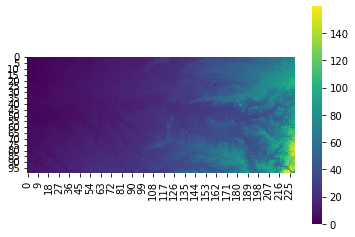

In [134]:
# np.savetxt(gwfm_dir+'\DIS_data\dem_44_7_200m_nearest.tsv', dem_data, delimiter = '\t')

# Based on Maribeth's grid aligned with Alisha's TPROGS model
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_nearest.tsv', delimiter = '\t')
dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_linear.tsv', delimiter = '\t')
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_44_7_200m_linear_missing_right_corner.tsv', delimiter = '\t')

# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_44_7_200m_nearest.tsv', delimiter = '\t')

import seaborn as sns
sns.heatmap(dem_data, cmap = 'viridis', vmin = 0,square=True)

# Capture cross section of deeper geology

In [135]:
# Pre-cretaceous metamorphic rocks - (variable thickness 200-500 ft thick)
# Ione formation (200 ft thick)
# Valley Springs formation (300 ft thick)
# Mehrten Formation (100 ft thick to 300 ft thick) (1-2 deg dip)
# Laguna Formation (less than 100 ft to between 200-300 ft thick) (less than 1 deg dip)
# upper formation (informed by well logs) (100 ft)
# ibound < 0 is constant head
# ibound = 0 is inactive cell
# ibound > 0 is active cell

## Need to adjust for change in model grid, based on Michigan Bar previously, maybe also look at effect of model domain angle vs cross section angle

In [136]:

# The stream gage at michigan bar is now 13 columns in from the boundary
# mehrtenbound

# Cross section E appears to have an angle of 0 compared to the model domain,

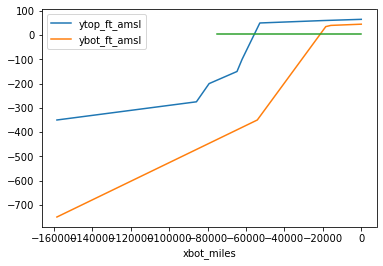

In [137]:
# # columns are xtop_miles, ytop_ft_amsl, xbot_miles, ytop_ft_amsl
# # XS upper bound should be at Michigan bar which is between Jackson road and Sacramento-Amador county line split
# # Mile 36 is approximately where Michigan bar aligns with the cross section
MB_XS_mile = 36
mehrtenbound = pd.read_csv(gwfm_dir+'/DIS_data/Mehrten_boundary_x_y.csv', parse_dates = False, 
                index_col = False, sep = ',', header = 'infer')
# Convert miles to feet and sets x value based on location of Michigan bar
# 0 is michigan bar and each major change in geologic dip is based on distance from Michigan Bar
mehrtenbound.xtop_miles = -5280*(MB_XS_mile - mehrtenbound.xtop_miles)
mehrtenbound.xbot_miles = -5280*(MB_XS_mile - mehrtenbound.xbot_miles)
# No flod boundary based on the original coordinates of the bottom of the Mehrten formation
mehrtenbound.noflow_x_miles = -5280*(MB_XS_mile - mehrtenbound.noflow_x_miles)

# East of mile 32 the entire vertical cross section, including up to the near entire surface
# is composed of old geologic formations that are not water bearing
volcanic_bound = (MB_XS_mile - 32)*-5280
# noflow_ind = int((1-(volcanic_bound/sumx))*ncol)

# Plot the x and y values
fig, ax = plt.subplots(1, 1)
mehrtenbound.plot(x = 'xtop_miles', y = 'ytop_ft_amsl', ax = ax)
mehrtenbound.plot(x = 'xbot_miles', y = 'ybot_ft_amsl', ax = ax)
plt.plot(-100*3.28*np.arange(0,len(dis.top[40,:])), np.flip(3.28*dis.top[40,:]))
# print(mehrtenbound)

In [138]:

def xy_to_botm(xbound_ft, ybound_ft, nspace,ntransversespace):
    laybotm = np.zeros((ntransversespace, nspace))
    # Nspace will be either nrow or ncol depending model direction
    # ntransversespace is the opposite of nspace (ie nrow if nspace is ncol)
    # Calculate the distance between each major change in dip
    dx = np.diff(xbound_ft)
    # Scale by the total distance across the coordinates to get percentages
    sumx = np.sum(dx)
    dx /= sumx
    # Multiply the number of columns by the percent of columns in each section of constant dip
    dx *= nspace
    # Round the number of columns to allow proper use for indexing
    nx = np.round(dx).astype(int)
    # Fix any discrepancy in number of columns due to issues with rouding the percentages of columns
    # Add a column to the last set of columns because there is already uncertainty at the deeper end
    while(np.sum(nx)-nspace !=0):
        if np.sum(nx)-nspace <0:
            nx[-1] += 1
        elif np.sum(nx)-nspace >0:
            nx[-1] -= 1
    sum(nx)

    # Now split the coordinates into downsized coordinates in between each major change in dip
    k = 0
    for i in np.arange(0,len(nx)):
        for j in np.arange(0,ntransversespace):
            laybotm[j, k:k+nx[i]] = np.arange(ybound_ft[i],ybound_ft[i+1], -(ybound_ft[i]-ybound_ft[i+1])/nx[i])
        k += nx[i]
    return(laybotm)

In [139]:
# X (east -west) and y (up-down vertical) of major dip changes for Mehrten Formation top boundary

mehrten_top = xy_to_botm(mehrtenbound.xtop_miles,mehrtenbound.ytop_ft_amsl, ncol, nrow)
# X (east -west) and y (up-down vertical) of major dip changes for Mehrten Formation bottom boundary
# drop na is because there are less values to mark changes in the bottom than top boundary
mehrten_bottom = xy_to_botm(mehrtenbound.xbot_miles.dropna(),mehrtenbound.ybot_ft_amsl.dropna(), ncol, nrow)

# Original x,y data for Mehrten bottom boundary to represent the noflow bounds
no_flow_bound = xy_to_botm(mehrtenbound.noflow_x_miles.dropna(), mehrtenbound.noflow_y_ft_amsl.dropna(),ncol,nrow)

## Alter existing botm for just TPROGS

In [140]:
botm = np.zeros((nlay, nrow, ncol))
# Convert units from ft to meters and flip to match direction
botm[-2,:,:] = np.flip(mehrten_top/3.28)
botm[-1,:,:] = np.flip(mehrten_bottom/3.28)
no_flow_bound = np.flip(no_flow_bound/3.28)
dis.botm = botm
# dis.plot()

## Adjustment to bottom boundary to ensure sufficient top layer thickness for the TPROGS model
Although the bottom boundaries are being artifically lowered to allow for sufficient layer thickness, this will be corrected when ibound is implemented based on where the actual bottom boundary is and where there is high elevations based on likelihood to be volcanics geology.

In [141]:
# The TPROGS model is 100m thick with some of it above the land surface
# to be safe, there should be at least 50 meters below ground surface to the bottom boundary

# Create 4 layers representing the upscaled "unsaturated" zone 
# ensures there is at least 1 m for each upscaled layer and rounded to create a clean boundary with the TPROGS data
leveling_layer_bottom = np.round(np.min(dem_data) - num_leveling_layers*1) 
leveling_layer_thickness = -10 # (dem_data - leveling_layer_bottom)/num_leveling_layers
botm[num_leveling_layers-1,:,:] = leveling_layer_bottom
for i in np.arange(num_leveling_layers-1,0,-1):
    botm[i-1,:,:] = botm[i,:,:] + leveling_layer_thickness
    
# Create TPROGS layers from top down
for i in np.arange(num_leveling_layers, num_leveling_layers + num_tprogs):
    botm[i,:,:] = botm[i-1,:,:] -tprog_thick
    
# Thickness to give to bottom layers below the TPROGS layers just to provide adequate spacing,
# this will be corrected by changing the geology in the layers above to account for what is actually in
# the Mehrten and what is in the Laguna formations, thickness of 5 also prevents any messy overlap
thickness_to_skip =10
# # Find where top boundary of Mehrten Formation rises within 10 meters of the top layer (10m for sufficient layer thickness)
bot3ind = np.min(np.where(botm[-2,:,:]>botm[-3,:,:]- thickness_to_skip)[1])

# # Where the top boundary of Mehrten was within 10 meters of the top layer 
# # set it equal to top layer elevation minus 10 for sufficient layer thickness
botm[-2,:,bot3ind:] = botm[-3,0,bot3ind]- thickness_to_skip
# # Repeat steps above for bottom of Mehrten formation with the top of the Mehrten formation
bot3ind = np.min(np.where(botm[-1,0,:]>botm[-2,0,:]- thickness_to_skip))
botm[-1,:,bot3ind:] = botm[-2,0,bot3ind]-thickness_to_skip

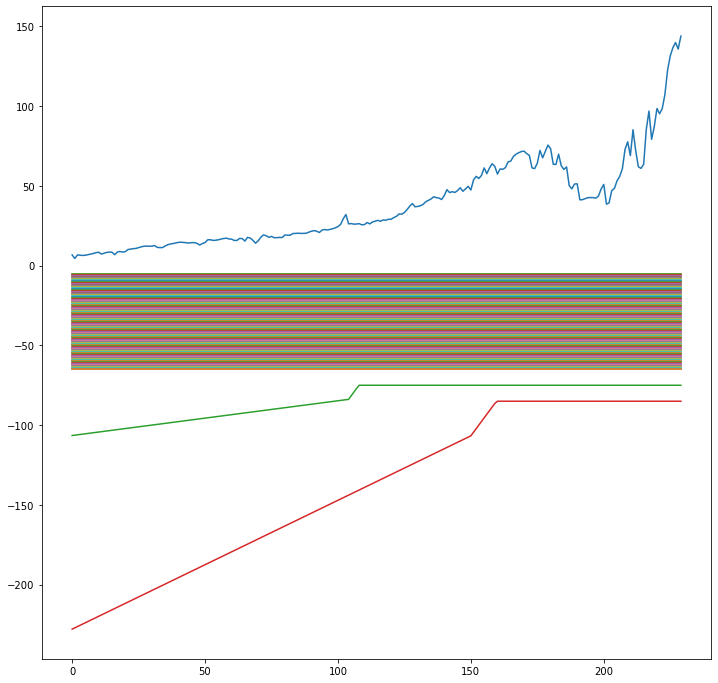

In [142]:
# when you apply the 1/200 aspect the dips in the cell seem a lot less severe, so may just leave the layering as is
# for now with 4 layers representing the unsaturated zone
fig,ax = plt.subplots(figsize = (12,12))
# ax.set_aspect(aspect = 1/10)
plotrow = 80
plt.plot(dem_data[plotrow,:])

for i in np.arange(0,nlay):
    plt.plot(botm[i,plotrow,:])

In [143]:
# Set the elevation of the top layer based on the DEM
m.dis.top = dem_data
# Bottom of model based on geology
m.dis.botm = botm
chk = dis.check()
chk.summary_array


DIS PACKAGE DATA VALIDATION:
  2760000 Errors:
    2760000 instances of thin cells (less than checker threshold of 1.0)

  Checks that passed:
    zero or negative thickness
    nan values in top array
    nan values in bottom array



rec.array([('Error', 'DIS',   1,  0,   0, 0.5, 'thin cells (less than checker threshold of 1.0)'),
           ('Error', 'DIS',   1,  0,   1, 0.5, 'thin cells (less than checker threshold of 1.0)'),
           ('Error', 'DIS',   1,  0,   2, 0.5, 'thin cells (less than checker threshold of 1.0)'),
           ...,
           ('Error', 'DIS', 120, 99, 227, 0.5, 'thin cells (less than checker threshold of 1.0)'),
           ('Error', 'DIS', 120, 99, 228, 0.5, 'thin cells (less than checker threshold of 1.0)'),
           ('Error', 'DIS', 120, 99, 229, 0.5, 'thin cells (less than checker threshold of 1.0)')],
          dtype=[('type', 'O'), ('package', 'O'), ('k', '<i4'), ('i', '<i4'), ('j', '<i4'), ('value', '<f8'), ('desc', 'O')])

## Complex ibound

### Define no flow cells based on elevation, informed by DWR cross sections and geologic maps of volcanic geology fingers leaving the mountains
In general, the location of Michigan Bar is near the boundary where there is total volcanics to majority alluvium. However there is a major finger North and South of the Cosumnes River of andesititc conglomerate, sandstone, breccia

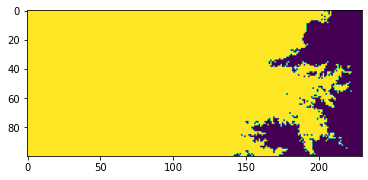

In [144]:
# Simplified ibound, only no flow cell if it is below the bottom of the Mehrten Formation
# Specify no flow boundary based on rough approx of geology (upper basin volcanics)
ibound = np.ones([nlay, nrow,ncol])
strt = np.ones((nlay, nrow, ncol), dtype = np.float32)
# The model should start in hydraulic connection
strt[:,:,:] = np.mean(m.dis.top[:,:], axis = 0)

cutoff_elev = 56
ibound = ibound*(dem_data<cutoff_elev)

plt.imshow(ibound[0,:,:])

### Create a line bounding the noflow region to set the specified head boundary

In [145]:
import pprint
from rasterio.features import shapes, rasterize

# The function shapes from rasterio requires uint8 format
ibound_line = ibound.astype(rasterio.uint8)
out = shapes(ibound_line,connectivity = 8)
alldata = list(out)

# maxl = 0
maxl = np.zeros(len(alldata))
for i in np.arange(0,len(alldata)):
    maxl[i] = len(alldata[i][0].get('coordinates')[0])
#     if len(alldata[i][0].get('coordinates')[0])>maxl:
#         maxl = len(alldata[i][0].get('coordinates')[0])
#         ind = i
# select the two longest linestring indexes (1st will be chunk down of divide (lower elevation) 2nd will chunk above (high elev))
maxl1, maxl2 = np.where(maxl>np.mean(maxl))[0]
print(maxl[maxl>np.mean(maxl)])

[647. 607.]


In [146]:
temp = alldata[maxl2][0].get('coordinates')[0]
tl = LineString(temp)
tl

In [147]:
from shapely.ops import LineString, linemerge, polygonize, unary_union
tl = LineString(temp)

# Get the constant head or general head boundary after the no flow cells
linerast = rasterio.features.rasterize([tl], out_shape = np.array((nrow,ncol)))
# remove far east bound line
linerast[:,ncol-1] = 0
fix_bound = np.min(np.argwhere(linerast[0,:]==1))
linerast[0,:] = 0
linerast[0,fix_bound]
np.shape(linerast)

# ibound[0,linerast==1] = -1

(100, 230)

In [148]:
from shapely.ops import LineString, linemerge, polygonize, unary_union
tl = LineString(temp)
tu = unary_union(tl)
poly = list(polygonize(tu))
# Set the polygon/raster for the top layer, no buffer needed
poly0 = poly[0].buffer(distance = 0)
polyrast0 = rasterio.features.rasterize([poly0], out_shape = np.array((nrow,ncol)))
# Set the polygon/raster for the top layer, slight buffer needed to expand geologic formation outward with depth as 
# naturally occurs
poly1 = poly[0].buffer(distance = 13)
polyrast1 = rasterio.features.rasterize([poly1], out_shape = np.array((nrow,ncol)))
# Set the polygon/raster for the bottom layer, largest buffer needed
poly2 = poly[0].buffer(distance = 17)
polyrast2 = rasterio.features.rasterize([poly2], out_shape = np.array((nrow,ncol)))

ibound = np.ones([nlay, nrow,ncol])
# Need to decide whether all layers or just the top layer are affected by ibound from elevation
# it is better to define the top layer with a simple dem>elevation check than the rasterize functins that isn't perfect
# ibound[0,polyrast0==1] = 0
# Need to decide whether all layers or just the top layer are affected by ibound from elevation
ibound[-2,polyrast1==1] = 0
# Need to decide whether all layers or just the top layer are affected by ibound from elevation
ibound[-1,polyrast2==1] = 0

# The bottom boundary has a dip of 1-2 degrees which is essentially a slope of 0.015 based on given cross section data
# The layer thickness for TPROGS
laythk = tprog_thick
# It appeared shapely buffer is on the scale of kilometers
run = (laythk/0.015)/1000
run_const = run
for i in np.arange(1,nlay-2):
    # error saying poly[i] is not subscriptable
    polyi = poly[0].buffer(distance = run)
    polyrast = rasterio.features.rasterize([polyi], out_shape = np.array((nrow,ncol)))
    # Need to decide whether all layers or just the top layer are affected by ibound from elevation
    ibound[i,polyrast==1] = 0
    run += run_const

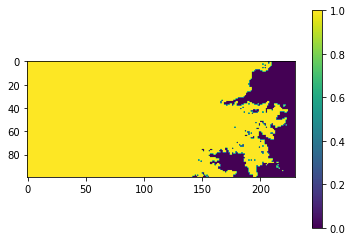

In [149]:
# wherever the constant head/specified head bound is the cells need to be active
ibound[0,dem_data>cutoff_elev] = 0
ibound[0,linerast==1] = 1
plt.imshow(ibound[0,:,:])
plt.colorbar()

In [150]:
# copy the ibound array to alter the geology array to set these cells as low permeability formations
# either marine or volcanic based
deep_geology = np.invert(ibound[:,:,:].astype(bool))

# reset ibound to all active cells to reduce non-linearity
# still need to take account of no flow cells for lake package
ibound = np.ones([nlay, nrow,ncol])

In [151]:
# np.savetxt(gwfm_dir+'/BAS6/deep_geology_'+str(nlay)'layer.tsv',np.reshape(deep_geology, (nlay*nrow,ncol)), delimiter ='\t')
# deep_geology = np.loadtxt(m.model_ws+'/input_data/deep_geology.tsv', delimiter ='\t')
# deep_geology = np.reshape(deep_geology, (nlay,nrow,ncol))

### Remove no flow cells in the first layer where there are stream cells

In [152]:
# where the specified head boundary is the cells must be active
# ibound[0,chd_locs[0], chd_locs[1]] = -1

In [153]:
# Basic package, BAS

# ibound < 0 is constant head
# ibound = 0 is inactive cell
# ibound > 0 is active cell
# strt is array of starting heads
bas = flopy.modflow.ModflowBas(model = m, ibound=ibound, strt = strt)

In [154]:
bas.check()



BAS6 PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    isolated cells in ibound array
    Not a number



## Read in TPROGS data

In [155]:
# "C:\Users\ajcalder\Box\research_cosumnes\Large_TPROGS_run\TPROGS_realizations\tsim_Cosumnes_Full_Model.asc1"
# create tprogs directory reference to 100 large tprogs runs ascii files
# tprogs_dir = os.path.dirname(gwfm_dir)+'/Large_TPROGS_run/Archive/TPROGS_realizations/'
# # get all file names
# tprogs_files = glob.glob(tprogs_dir+'*')


In [156]:
mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')


In [157]:
gel_dir = gwfm_dir+'/UPW_data'
if 'ZonePropertiesInitial.csv' in os.listdir(model_ws):
    params = pd.read_csv(model_ws+'/ZonePropertiesInitial.csv',index_col='Zone')
else:
    params = pd.read_csv(gel_dir+'/ZonePropertiesInitial.csv',index_col='Zone')
    params.to_csv(model_ws+'/ZonePropertiesInitial.csv')
# convert from m/s to m/d
params['K_m_d'] = params.K_m_s * 86400    

In [158]:
def tprogs_cut_elev(tprogs_line, dem_data, **kwargs):
    rows = kwargs.get('rows', np.where(np.ones(dem_data.shape)==1)[0])
    cols = kwargs.get('cols', np.where(np.ones(dem_data.shape)==1)[1])
    tprogs_arr = np.reshape(tprogs_line, (320, 100,230))
    tprogs_c = np.reshape(tprogs_arr[:, rows,cols],
                             (tprogs_arr.shape[0],dem_data.shape[0],dem_data.shape[1]))
    tprogs_elev = np.copy(tprogs_c)
    # the bottom layer of the tprogs model is at -50 m amsl and the top layer is 50 m amsl
    t = 0
    for k in np.arange(-80,80,0.5):
        tprogs_elev[t,dem_data<k]= np.NaN
        t+=1
    masked_tprogs = ma.masked_invalid(tprogs_elev)
    return(masked_tprogs)

In [159]:
import numpy.ma as ma
def tprogs_cut_saturated(tprogs,kriged):
    tprogs_unsat = np.copy(tprogs)
    # the bottom layer of the tprogs model is at -80 m amsl and the top layer is 80 m amsl
    # set any tprogs cells below the average fall water table depth as np.nan
    t = 0
    for k in np.arange(-80,80,0.5):
        tprogs_unsat[t,kriged>k]= np.NaN
        t+=1
    masked_tprogs = ma.masked_invalid(tprogs_unsat)
    return(masked_tprogs)

In [160]:
def int_to_param(tprogs):
    tprogs[tprogs<0] *= -1
    tprogs = tprogs.astype(float)
    # flip tprogs model along z axis to match modflow definition of 0 as top (TPROGS says 0 is bottom)
    tprogs = np.flip(tprogs,axis=0)
    tprogs_K = np.copy(tprogs)
    tprogs_Sy = np.copy(tprogs)
    tprogs_Ss = np.copy(tprogs)
    # hydraulic parameters from fleckenstein 2006
    # I-IV gravel, sand, muddy sand, mud
    # K in m/s, Sy, Ss
    for n in np.arange(1,5):
        tprogs_K[tprogs==n]= params.loc[n,'K_m_d']
    for n in np.arange(1,5):
        tprogs_Sy[tprogs==n]= params.loc[n,'Sy']
    for n in np.arange(1,5):
        tprogs_Ss[tprogs==n]= params.loc[n,'Ss']
            
    return(tprogs_K,tprogs_Sy,tprogs_Ss)


In [161]:
t=0
tprogs_line = np.loadtxt(tprogs_files[t])
masked_tprogs=tprogs_cut_elev(tprogs_line, dem_data)
K, Sy, Ss= int_to_param(masked_tprogs)


In [162]:
# the first layer starts at -10 m which corresponds to 20 layers below 0
# 0m AMSL is 160 layers above the bottom of tprogs which ends up giving 160-20 is layer 140 or 139 for 0 based

## LPF/UPW package

In [163]:
def elev_to_tprogs_layers(elev):
    # function to get the tprogs layers based on the given elevation
    # layer 0 is 80 meters, layer 1 is 79.5 meters, layer -1 is -80 meters
    elev_05 = np.round((elev) * 2) / 2 # dem rounded to the nearest 0.5
    elev_05[elev_05 >= 80] = 80# any elevation above 80 m is set to 80
    elev_indices = 160 - elev_05*2 # subtract the calculated row from 160 to get to 0 at 160 and 320 and -160
    return(elev_indices.astype(int))
    
def get_tprogs_for_elev(tprogs_arr, top_elev, bot_elev, **kwargs):
    rows = kwargs.get('rows', np.where(np.ones(top_elev.shape)==1)[0])
    cols = kwargs.get('cols', np.where(np.ones(top_elev.shape)==1)[1])
    top_indices = elev_to_tprogs_layers(top_elev)
    bot_indices = elev_to_tprogs_layers(bot_elev)
    # find tprogs layer for desired rows and columns
    top_indices = top_indices[rows, cols].astype(int)
    bot_indices = bot_indices[rows, cols].astype(int)
    # the first row of the array will be the top layer and will progress downward until the max bottom is reached
    # with NaNs for rows,cols where there are less layers indexed than the max
    tprogs_subset = np.full(shape = (np.max(bot_indices - top_indices).astype(int), len(rows)),
                       fill_value = np.nan, dtype = float)
    max_layers = np.max(bot_indices - top_indices)
    for k in np.arange(0,max_layers):
        layexist = (bot_indices-top_indices) > k # pick where data should be referenced
        tprogs_subset[k, layexist] = tprogs_arr[top_indices[layexist]+k, rows[layexist], cols[layexist]]
    # return grabbed data in array format if entire domain was used
    if len(rows) == top_elev.shape[0]*top_elev.shape[1]:
        tprogs_subset = np.reshape(tprogs_subset, (max_layers, top_elev.shape[0], top_elev.shape[1]))
    # mask na values so they don't cause issues with gmean or hmean
    tprogs_subset = ma.masked_array(tprogs_subset, mask = np.isnan(tprogs_subset))
    return(tprogs_subset)

In [164]:
hk = np.zeros(botm.shape)
vka = np.zeros(botm.shape)
sy = np.zeros(botm.shape)
ss = np.zeros(botm.shape)

In [165]:
# # take of 2 for the bottom layers and 1 for the unsat zone layer up top
# # for tprogs arrays 0 is the bottom of the model, so flipping on z will fix
hk[1:-2,:,:] = np.flip(K[-hk.shape[0]+1:-2,:,:],axis=0)
#need to set anisotropy for TPROGs, may not matter for this
vka[1:-2,:,:] = np.flip(K[-hk.shape[0]+1:-2,:,:],axis=0)
sy[1:-2,:,:] = np.flip(Sy[-sy.shape[0]+1:-2,:,:],axis=0)
ss[1:-2,:,:] = np.flip(Ss[-ss.shape[0]+1:-2,:,:],axis=0)


The LPF package should use the means for the complete TPROGs layers available for the first layer

In [166]:
from scipy.stats import hmean
lay1_HK = np.mean(get_tprogs_for_elev(K, m.dis.top.array, m.dis.botm.array[0,:,:]),axis=0)
lay1_VK = hmean(get_tprogs_for_elev(K, m.dis.top.array, m.dis.botm.array[0,:,:]),axis=0)
lay1_Sy = np.mean(get_tprogs_for_elev(Sy, m.dis.top.array, m.dis.botm.array[0,:,:]),axis=0)
lay1_Ss = np.mean(get_tprogs_for_elev(Ss, m.dis.top.array, m.dis.botm.array[0,:,:]),axis=0)



In [167]:
# set parameters based on upscaled unsaturated zone
hk[0,:,:] = lay1_HK
vka[0,:,:] = lay1_VK
sy[0,:,:] = lay1_Sy
ss[0,:,:] = lay1_Ss

The tuff breccia is very dense, hard and low water yielding. It is supposedly responsible for the many "haystack" hills in the eastern part of the county

DWR report has a few final well pumping rates, drawdowns and specific capacities but limited.

Fleckenstein et al. 2006 found the Mehrten had
Kh = 1 to 1.8 x10^-5 m/s
Kv = 1 to 1.8 x10^-7 m/s
Sy = 0.15 to 0.2
Ss = 1e-4 to 1e-3 m^-1

In [168]:
# set values for second to bottom layer, Laguna formation
hk[-2,:,:] = params.loc[5,'K_m_d']
vka[-2,:,:] = params.loc[5,'K_m_d']/params.loc[5,'VANI'] # assume 1/100 for Kx to Kz
sy[-2,:,:] = params.loc[5,'Sy']
ss[-2,:,:] = params.loc[5,'Ss']

# the deep_geology array shows where the mehrten formation comes out of the surface
hk[deep_geology[:,:,:].astype(bool)] = params.loc[6,'K_m_d']
vka[deep_geology[:,:,:].astype(bool)] = params.loc[6,'K_m_d']/params.loc[6,'VANI'] # assume 1/100 for Kx to Kz
sy[deep_geology[:,:,:].astype(bool)] = params.loc[6,'Sy']
ss[deep_geology[:,:,:].astype(bool)] = params.loc[6,'Ss']

# set values for bottom layer, Mehrten formation
hk[-1,:,:] = params.loc[6,'K_m_d']
vka[-1,:,:] = params.loc[6,'K_m_d']/params.loc[6,'VANI'] # assume 1/100 for Kx to Kz
sy[-1,:,:] = params.loc[6,'Sy']
ss[-1,:,:] = params.loc[6,'Ss']

In [169]:
# layvka 0 means vka is vert K, non zero means its the anisotropy ratio between horiz and vert
layvka = 0

# LAYTYP MUST BE GREATER THAN ZERO WHEN IUZFOPT IS 2
# 0 is confined, >0 convertible, <0 convertible unless the THICKSTRT option is in effect
# laytyp = np.ones(nlay)  
laytyp = np.zeros(nlay)
# Laywet must be 0 if laytyp is confined laywet = [1,1,1,1,1]
laywet = np.zeros(len(laytyp))
laywet[laytyp==1] = 1
#ipakcb = 55 means cell-by-cell budget is saved because it is non zero (default is 53)

# until upscaling is begun then vertical and horiz K are the same for TPROGS
# upw = flopy.modflow.ModflowUpw(model = m, hk =hk, layvka = layvka, vka = hk, sy=sy, ss=ss,
#             laytyp=laytyp, ipakcb=55)

lpf = flopy.modflow.ModflowLpf(model = m, hk =hk, layvka = layvka, vka = hk, sy=sy, ss=ss,
                               laytyp=laytyp, laywet = laywet, ipakcb=55)

## CHD Package Time variant head
May need to remove Mehrten formation and leave Laguna as bottom to avoid having very low conductivity layer causing water mounding, but still need Laguna formation to balance out the layer in the bottom layer with TPROGs.

In [170]:
chd = flopy.modflow.ModflowChd(model=m,ipakcb=55)

In [171]:
# model top constant head boundary
chd_df = grid_p.copy()
chd_df = chd_df.drop(['geometry','node'],axis=1)
chd_df.row -= 1
chd_df.column -=1
chd_df['layer'] = 0
chd_df['head'] = m.dis.top.array[chd_df.row, chd_df.column]
# model bottom constant head boundary

chd_bot = chd_df.copy()
chd_bot.layer = m.dis.nlay-1
chd_bot['head'] = m.dis.botm.array[chd_bot.layer[0], chd_bot.row, chd_bot.column]
chd_df = chd_df.append(chd_bot)

# prep format for MF input: layer, row, column, shead, ehead
chd_arr = chd_df.loc[:,['layer','row','column','head','head']].values
chd.stress_period_data =  {0: chd_arr}
chd.check()


CHD PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    BC indices valid
    not a number (Nan) entries
    BC in inactive cells



## Output Control

In [172]:
# Output control
# default unit number for heads is 51, cell by cell is 53 and drawdown is 52
# (0,0) is (stress period, time step)

# For later model runs when all the data is needed to be saved
spd = { (j,0): ['save head', 'save budget'] for j in np.arange(0,nper,1)}

# get the first of each month to print the budget
month_intervals = (pd.date_range(strt_date,end_date, freq="MS")-pd.to_datetime(strt_date)).days

for j in month_intervals:
    spd[j,0] = ['save head', 'save budget','print budget']
    
oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True)

## Newton Solver

In [173]:
# m.version = 'mfnwt'
# m.exe_name = 'mf-nwt.exe'

In [174]:
# pcg = flopy.modflow.ModflowPcg(model = m)
# nwt = flopy.modflow.ModflowNwt(model= m)
# thickfact: portion of cell thickness used for smoothly adjusting storage and conductance coefficients to zero (default is 1e-5)
# linmeth (linear method): 1 for GMRES and 2 for XMD (1 is default)
# iprnwt: flag whether additional info about solver convergence will be printed to the main listing file (default is 0)
# ibotav: flag whether corretion will be made to gw head relative to cell-bottom if surrounded by dry cells.
# 1 = corrections and  0 = no correction (default is 0)
# options: specify comlexity of solver. SIMPLE : default solver for linear models, MODERATE for moderately nonlinear models,
# COMPLEX for highly nonlinear models (default is COMPLEX)
# Continue: if model fails to converge during a time step it will continue to solve the next time step (default is False) 
# epsrn (XMD) is the drop tolerance for preconditioning (default is 1E-4)
# hclosexmd (XMD) head closure criteria for inner (linear) iterations (default 1e-4)

# solver = flopy.modflow.ModflowNwt(model = m, headtol=0.01, fluxtol=500, maxiterout=200, thickfact=1e-05, 
#                                linmeth=1, iprnwt=1, ibotav=0, options='MODERATE', Continue=False,
#                                maxbackiter=50, backtol=1.1, maxitinner=50, ilumethod=2, 
#                                levfill=5, stoptol=1e-10, msdr=15, iacl=2, norder=1, level=5, north=7, 
#                                iredsys=0, rrctols=0.0, idroptol=1, epsrn=0.0001, hclosexmd=0.0001, 
#                                mxiterxmd=50, extension='nwt', unitnumber=27)

# solver = flopy.modflow.ModflowNwt(model = m,options='MODERATE', Continue=False,
#                                extension='nwt', unitnumber=28, filenames='MF.nwt.out')

# GMG is more successful than pcg which is fine for steady state model
# mxiter, max outer, iiter = max inner, hclose = head change criterion for convergence, 
# rclose = residual criterion for convergence

# solver = flopy.modflow.ModflowGmg(model = m, mxiter=50, iiter=30, hclose = 1e-5, rclose = 1e-5)

In [175]:
# nwt.write_file()

In [176]:
max_outer = 200
max_inner = 100
# iter_mo max outer iters, ter_mi = max inner iters, close_r residual criterion for stopping iteration
# close_h is alternate criterion for nonlinear problem, and is head closure which should be smaller than residual closer
# ipunit =0 means no info on solver, ipunit=1 means output about solver issues is written
# if iter_mo >1 then closer_r is used not close_h and closer_r is compared to 
# the square root of the inner product of the residuals (the residual norm)
# adamp =0 is std damping, adamp=1 is adaptive damping that further decreases or increases damping based on picard
# iteration sucess
#adamp is 0.7 to resolve issues with heads oscillating near solution +1 m
# damp_lb = lower bound, rate_d is rate of increase of damping based picard iteration success

# solver = flopy.modflow.ModflowPcgn(m, max_outer = max_outer, max_inner=max_inner, close_r=1e-01, close_h=1e-02, ipunit=28) 
#                                 relax = 0.99, ifill=1)
#                                adamp=1, damp=0.7, damp_lb=0.1, rate_d=0.01)


# mxiter = max outer iterations, iter1 = max inner iterations
solver = flopy.modflow.ModflowPcg(m, mxiter = max_outer, iter1=max_inner, rclose=1e-01, hclose=1e-03)
#                                adamp=1, damp=0.7, damp_lb=0.1, rate_d=0.01)


# solver = flopy.modflow.ModflowDe4(m, itermx = max_inner, hclose=1E-2)
# solver = flopy.modflow.ModflowSip(m, mxiter = max_inner, hclose=1e-02)


In [177]:
# solver.write_file()

In [178]:
# m.exe_name = 'mf2005.exe' #MODFLOW-NWT.exe
# m.version = 'mf2005' #mfnwt

In [179]:
m.get_package_list()
# m.remove_package('DATA')
# m.remove_package('LAK')
# m.remove_package('WEL')
# m.remove_package('RCH')
# m.remove_package('NWT')

['DIS', 'BAS6', 'LPF', 'CHD', 'OC', 'PCG']

In [180]:

m.check()
# lak.check()
# upw.check()


MF MODEL DATA VALIDATION SUMMARY:
  2760000 Errors:
    DIS package: thin cells (less than checker threshold of 1.0)

  Checks that passed:
    Unit number conflicts
    Compatible solver package
    DIS package: zero or negative thickness
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: zero or negative vertical hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    LPF package: vertical hydraulic conductivity values below checker threshold of 1e-11
    LPF package: vertical hydraulic conductivity values above checker threshold of 100000.0
    LPF package: zero or 

## Write the input files

In [181]:
# loadpth = 'C:/WRDAPP/GWFlowModel/Cosumnes_Blodgett_10yr/'
# model_ws = loadpth+'WEL_SFR_RCH_layercake'
# m = flopy.modflow.Modflow.load('MF.nam',model_ws = model_ws)

In [182]:
m.model_ws

'C:/WRDAPP/GWFlowModel/Cosumnes/levee_setback_distance_analysis/Permeameter_for_velocity'

In [185]:
# Writing the MODFLOW data files
m.write_input()
